In [362]:
import pandas as pd
import itertools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu


In [363]:
# Set global matplotlib and seaborn style parameters
import matplotlib as mpl
new_rc_params = {
    'text.usetex': False,
    "svg.fonttype": 'none'
}
mpl.rcParams.update(new_rc_params)
mpl.rcParams["font.family"] = "Arial"

npg_palette = ["#E64B35FF", "#4DBBD5FF", "#00A087FF", "#3C5488FF", "#F39B7FFF"]
npg_palette2 = ["#8491B4FF", "#91D1C2FF", "#DC0000FF", "#7E6148FF", "#B09C85FF"]
sns.set_palette(npg_palette)
sns.set_style('white', {'axes.linewidth': 0.85})

plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

In [364]:
species_list = ['dmel', 'dsim', 'dana', 'dvir', 'sleb']

# read in the orthomcl file
orthomcl_file = 'groups_g.txt'
groups = pd.read_csv(orthomcl_file, sep=':', header=None, names=['cluster', 'group'])

# extract the species each group has
groups['species'] = groups['group'].apply(lambda x: ', '.join(dict.fromkeys(pd.Series(x.split()).str.extract(r'(\w+)\|')[0].dropna())) if x else None)

# create a new column for each species with the gene names
for species in ['dmel', 'dsim', 'dana', 'dvir', 'sleb']:
    groups[f'{species}_gene'] = (
        groups['group']
        .str.findall(fr'{species}\|(\S+)')  # Find all gene matches for the species
        .apply(lambda x: ','.join(x) if x else None)  # Convert list to comma-separated string
    )
# create a new column for each species with the count of genes in the species
for sp in species_list:
    col_name = sp + '_count'
    groups[col_name] = groups['group'].apply(lambda x: x.count(sp))

# get genes shared by all species
gene_shared_all = groups[groups['species']=='dmel, dsim, dana, dvir, sleb']
gene_shared_all_1 = gene_shared_all[gene_shared_all.iloc[:, -5:].eq(1).all(axis=1)]

# extract gene names
gene_shared_all_1[['dmel_gene', 'dsim_gene', 'dana_gene', 'dvir_gene', 'sleb_gene']] = (
    gene_shared_all_1['group']
    .str.extract(r'dmel\|(\S+).*dsim\|(\S+).*dana\|(\S+).*dvir\|(\S+).*sleb\|(\S+)')
)

/var/folders/jt/wf6lflrs1_94wjjrq_r5mrvm0000gn/T/ipykernel_31171/2552034045.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene_shared_all_1[['dmel_gene', 'dsim_gene', 'dana_gene', 'dvir_gene', 'sleb_gene']] = (


In [365]:
from Bio import SeqIO

fasta_file = "dmel-all-translation-r6.48.fasta"  # Replace with your file path

records = []
for record in SeqIO.parse(fasta_file, "fasta"):
    header = record.description
    protein_id = record.id

    # Extract gene ID from "parent=" field
    gene_match = re.search(r'parent=([^;,]+)', header)
    gene_id = gene_match.group(1) if gene_match else None

    # Extract length from "length=" field
    length_match = re.search(r'length=(\d+)', header)
    length = int(length_match.group(1)) if length_match else len(record.seq)

    records.append({
        'protein_id': protein_id,
        'gene_id': gene_id,
        'length': length
    })

# Convert to dataframe
df_length = pd.DataFrame(records)




In [43]:
species_list = ['dmel', 'dsim', 'dana', 'dvir','sleb']

In [367]:
# Load data
df_ef = pd.read_csv('combined_res_singlecopy_ef.txt', sep = '\t')


In [368]:
def pivot(df):
    # remove genes with missing or non-numeric log2FC
    df = df.dropna(subset=['log2FoldChange'])

    # Pivot the table to wide format: one row per gene, one column per species
    pivot_df = df.pivot_table(index='gene', columns='species', values='log2FoldChange')

    # Drop genes missing in any species (optional)
    pivot_df = pivot_df.dropna()

    pivot_df = pivot_df.reset_index()

    pivot_df = pivot_df.rename_axis(None, axis=1)  # Remove the index name

    return pivot_df

In [369]:
pivot_df_ef = pivot(df_ef)

In [376]:
pivot_df_ef

,gene,dana,dmel,dsim,dvir,sleb,s_mean,r_mean
0,FBgn0000008,0.139352,-0.342289,-0.059773,-0.413008,0.446705,-0.087570,0.016849
1,FBgn0000014,0.718884,0.179447,0.402258,-0.419714,-0.518676,0.433530,-0.469195
2,FBgn0000015,0.645394,0.086736,0.613424,-0.843325,-0.876916,0.448518,-0.860120
3,FBgn0000017,-0.091866,-0.586405,-0.105105,-0.152350,0.968657,-0.261125,0.408153
4,FBgn0000018,-0.231488,-0.185042,-0.174796,-0.250423,0.811701,-0.197109,0.280639
...,...,...,...,...,...,...,...,...
8402,FBgn0288857,-0.167838,0.166296,-0.000021,-0.113867,-0.300182,-0.000521,-0.207025
8403,FBgn0288875,-0.234209,-0.259209,-0.155031,-0.194883,0.718871,-0.216150,0.261994
8404,FBgn0288888,0.465259,0.179235,0.224754,0.115778,-0.608703,0.289750,-0.246462
8405,FBgn0288966,-0.345767,-0.361419,-0.115823,0.446102,0.433310,-0.274336,0.439706


In [375]:
pivot_df_ef['s_mean'] = pivot_df_ef[['dmel', 'dsim', 'dana']].mean(axis=1)
pivot_df_ef['r_mean'] = pivot_df_ef[['dvir', 'sleb']].mean(axis=1)
                                    

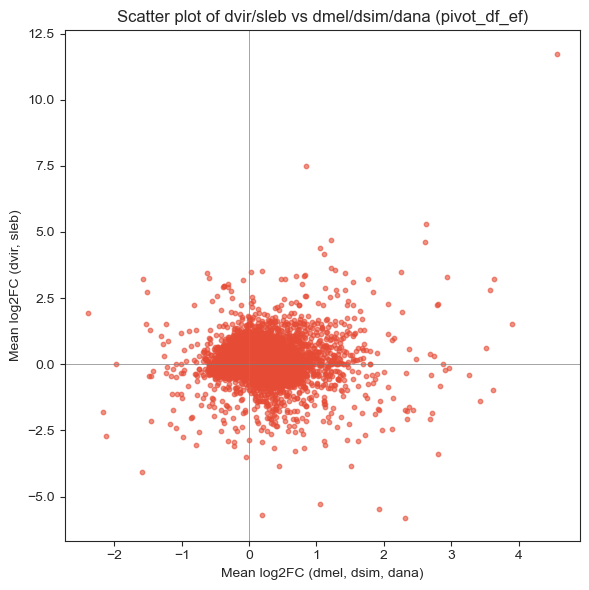

In [378]:
# Scatter plot: dvir/sleb vs dmel/dsim/dana for each gene in pivot_df_ef

fig, ax = plt.subplots(figsize=(6, 6))

# For each gene, plot (mean of dmel/dsim/dana, mean of dvir/sleb)
x = pivot_df_ef[['dmel', 'dsim', 'dana']].mean(axis=1)
y = pivot_df_ef['dvir']

ax.scatter(x, y, alpha=0.6, s=10)
ax.set_xlabel('Mean log2FC (dmel, dsim, dana)')
ax.set_ylabel('Mean log2FC (dvir, sleb)')
ax.set_title('Scatter plot of dvir/sleb vs dmel/dsim/dana (pivot_df_ef)')
plt.axhline(0, color='grey', lw=0.5)
plt.axvline(0, color='grey', lw=0.5)
plt.tight_layout()
plt.show()

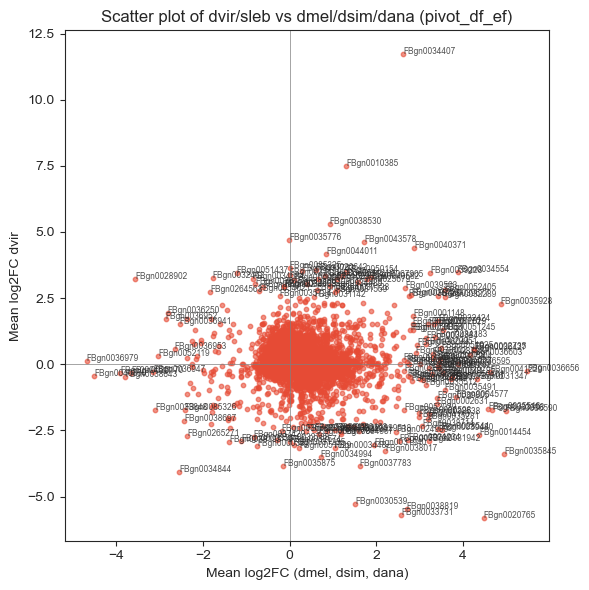

In [427]:
fig, ax = plt.subplots(figsize=(6, 6))

# Calculate group means
x = pivot_df_ef['dana']
y = pivot_df_ef['dvir'] # corrected y-axis to match title

# Scatter plot
ax.scatter(x, y, alpha=0.6, s=10)

# Set axis labels and title
ax.set_xlabel('Mean log2FC (dmel, dsim, dana)')
ax.set_ylabel('Mean log2FC dvir')
ax.set_title('Scatter plot of dvir/sleb vs dmel/dsim/dana (pivot_df_ef)')
ax.axhline(0, color='grey', lw=0.5)
ax.axvline(0, color='grey', lw=0.5)

# Define thresholds for labeling outer points
x_mean, x_std = x.mean(), x.std()
y_mean, y_std = y.mean(), y.std()

threshold_x = 4 * x_std
threshold_y = 4 * y_std

# Annotate outer points
for gene_id in pivot_df_ef.index:
    x_val = x[gene_id]
    y_val = y[gene_id]
    if abs(x_val - x_mean) > threshold_x or abs(y_val - y_mean) > threshold_y:
        ax.text(x_val, y_val, pivot_df_ef.iloc[gene_id,0], fontsize=6, alpha=0.8)

plt.tight_layout()
plt.show()


In [319]:
susceptible_group = ['dmel', 'dsim', 'dana']
resistant_group = ['dvir', 'sleb']

candidate_ef = pivot_df_ef[
    (pivot_df_ef[susceptible_group] < 2).all(axis=1) &
    (pivot_df_ef[resistant_group] > 2).all(axis=1)
]

In [ ]:
merged_ef = candidate_ef.merge(df_length, left_on='gene', right_on='gene_id', how='left')
merged_ef = merged_ef.drop_duplicates(subset=['gene'], keep='first')
m1_ef = merged_ef[merged_ef['length'] < 200]

In [322]:
m1_ef

,gene,dana,dmel,dsim,dvir,sleb,protein_id,gene_id,length
0,FBgn0010385,1.309616,0.853936,0.374812,7.506368,5.134446,FBpp0087518,FBgn0010385,92
15,FBgn0037176,1.211511,0.437421,0.565947,2.241301,7.494272,FBpp0078170,FBgn0037176,198
18,FBgn0051802,1.211503,0.057866,0.937335,2.225943,22.451577,FBpp0080611,FBgn0051802,186
19,FBgn0054021,-0.712043,0.673660,-0.768649,2.770584,4.652989,FBpp0099432,FBgn0054021,161
20,FBgn0264563,-1.835924,-2.692970,0.000000,2.730316,6.055604,FBpp0305617,FBgn0264563,42


In [396]:
# Load data
df_pr = pd.read_csv('combined_res_singlecopy_pr.txt', sep = '\t')


In [397]:
pivot_df_pr = pivot(df_pr)
pivot_df_pr

,gene,dana,dmel,dsim,dvir,sleb
0,FBgn0000008,-0.118885,0.011720,0.046758,0.220984,0.258320
1,FBgn0000014,-0.528600,0.043210,-0.450109,-0.153791,0.188975
2,FBgn0000015,-0.028181,0.171329,-0.524662,0.286869,0.118799
3,FBgn0000017,-0.206270,-0.153630,0.136016,0.242323,-0.151967
4,FBgn0000018,-0.107257,-0.127304,-0.100603,0.224083,-0.177318
...,...,...,...,...,...,...
8107,FBgn0288857,0.291099,-0.055181,0.198171,-0.085726,-0.103165
8108,FBgn0288875,-0.194402,-0.105494,-0.040200,0.128413,-0.160484
8109,FBgn0288888,0.419179,0.035695,0.039447,-0.724910,0.588225
8110,FBgn0288966,-0.124823,0.039814,-0.241299,0.031089,0.029764


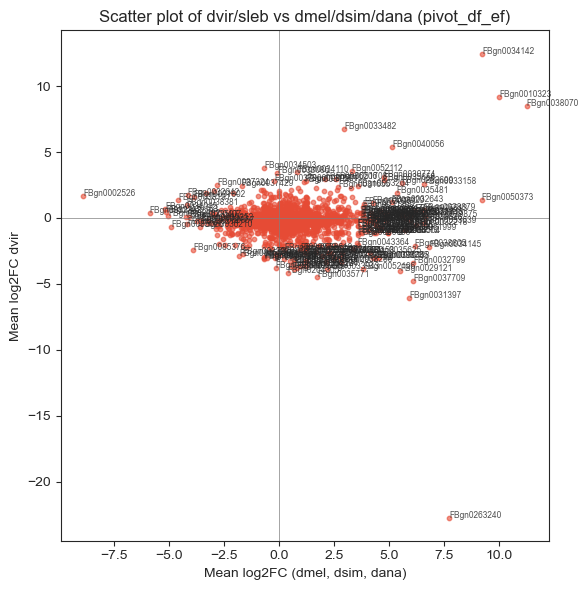

In [429]:
fig, ax = plt.subplots(figsize=(6, 6))

# Calculate group means
x = pivot_df_pr['dana']
y = pivot_df_pr['dvir'] # corrected y-axis to match title

# Scatter plot
ax.scatter(x, y, alpha=0.6, s=10)

# Set axis labels and title
ax.set_xlabel('Mean log2FC (dmel, dsim, dana)')
ax.set_ylabel('Mean log2FC dvir')
ax.set_title('Scatter plot of dvir/sleb vs dmel/dsim/dana (pivot_df_ef)')
ax.axhline(0, color='grey', lw=0.5)
ax.axvline(0, color='grey', lw=0.5)

# Define thresholds for labeling outer points
x_mean, x_std = x.mean(), x.std()
y_mean, y_std = y.mean(), y.std()

threshold_x = 4 * x_std
threshold_y = 4 * y_std

# Annotate outer points
for gene_id in pivot_df_pr.index:
    x_val = x[gene_id]
    y_val = y[gene_id]
    if abs(x_val - x_mean) > threshold_x or abs(y_val - y_mean) > threshold_y:
        ax.text(x_val, y_val, pivot_df_ef.iloc[gene_id,0], fontsize=6, alpha=0.8)

plt.tight_layout()
plt.show()


In [335]:
candidate_pr = pivot_df_pr[
    (pivot_df_pr[susceptible_group] < 2).all(axis=1) &
    (pivot_df_pr[resistant_group] > 2).all(axis=1)
]

In [336]:
merged_pr = candidate_pr.merge(df_length, left_on='gene', right_on='gene_id', how='left')

In [338]:
m1_pr = merged_pr[merged_pr['length'] < 200]

In [46]:
ef_tpm = {}
pr_tpm = {}
for species in species_list:
    ef_tpm[species] = pd.read_csv(f'ef_TPM/{species}_comb_TPM.txt', sep='\t')
    pr_tpm[species] = pd.read_csv(f'pr_TPM/{species}_comb_TPM.txt', sep='\t')

In [408]:
ef_tpm['dmel']

,Gene ID,Gene Name,Reference,Strand,Start,End,Coverage,FPKM,TPM,TPM.1,TPM.2,TPM.3,TPM.4,TPM.5,TPM.6,TPM.7,TPM.8
0,FBgn0000003,-,3R,+,6822500,6822798,126.142143,11.240629,22.220989,28.543163,28.231829,85.109276,203.494385,27.165487,123.515831,9.832008,13.965665
1,FBgn0000008,-,2R,+,22136968,22172834,62.059788,6.239894,12.335308,12.418184,12.285198,8.382042,8.670142,8.499274,8.237565,8.515184,8.635385
2,FBgn0000014,-,3R,-,16807214,16830049,16.967501,1.699117,3.358893,3.210651,2.735980,2.773699,2.565962,2.906984,3.049252,3.066708,3.222280
3,FBgn0000015,-,3R,-,16927212,16972236,2.328086,0.899679,1.778526,1.593356,1.454261,1.168659,1.376077,1.225101,1.596454,1.199124,1.508326
4,FBgn0000017,-,3L,-,16615866,16647882,95.758858,10.359592,20.479317,21.928989,23.260334,11.463178,12.454405,12.785860,13.055028,13.276916,13.876315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17891,FBgn0288857,-,X,-,13385914,13387417,193.917603,19.295794,38.144806,37.336220,36.949528,35.909821,39.330524,37.677929,35.900288,36.568310,37.474277
17892,FBgn0288875,-,3R,-,29059272,29062975,238.700455,21.270792,42.049072,40.544453,44.083679,28.113665,32.366127,29.796722,29.813465,29.574574,32.717613
17893,FBgn0288888,-,3R,+,26440778,26448991,8.667772,0.816401,1.613898,1.402054,1.262431,1.426795,1.313461,1.707855,1.582023,1.034157,1.759216
17894,FBgn0288966,-,3R,+,31611046,31615375,180.801453,16.526772,32.670879,33.418743,32.763046,21.170675,22.574278,21.795130,21.616051,22.336380,22.176725


In [405]:
def plot_tpm(bac, gene_id):
    group_labels = ['untreated', 'pbs', 'bacteria']
    species_list = ['dmel', 'dsim', 'dana', 'dvir', 'sleb']

    bar_means = []
    bar_stds = []
    bar_species = []
    x_labels = []
    colors = []
    npg_palette = ["#E64B35FF", "#4DBBD5FF", "#00A087FF", "#3C5488FF", "#F39B7FFF"]
    species_colors = dict(zip(species_list, npg_palette))

    for species in species_list:
        if bac == 'ef':
            df = ef_tpm[species]
        elif bac == 'pr':
            df = pr_tpm[species]

        # Find species-specific gene ID using the shared ortholog table
        if species == 'dmel':
            gene_id_species = gene_id
        else:
            match_row = gene_shared_all_1[gene_shared_all_1['dmel_gene'] == gene_id]
            if match_row.empty or pd.isna(match_row[f'{species}_gene'].values[0]):
                print(f"No ortholog found for {gene_id} in {species}")
                continue
            gene_id_species = match_row[f'{species}_gene'].values[0]

        # Get the row for the gene in this species
        try:
            if species == 'dmel':
                row_idx = df[df['Gene ID'] == gene_id_species].index[0]
            else:
                row_idx = df[df['Gene Name'] == gene_id_species].index[0]
        except IndexError:
            print(f"Gene {gene_id_species} not found in {species}")
            continue

        row_data = df.iloc[row_idx, -9:].astype(float)

        means = [row_data.values[j:j+3].mean() for j in range(0, 9, 3)]
        stds = [row_data.values[j:j+3].std(ddof=1) for j in range(0, 9, 3)]

        bar_means.extend(means)
        bar_stds.extend(stds)
        bar_species.extend([species] * 3)
        x_labels.extend([f"{species}_{g}" for g in group_labels])
        colors.extend([species_colors[species]] * 3)

    # Plot
    x = np.arange(len(bar_means))
    fig, ax = plt.subplots(figsize=(6, 3))
    ax.bar(x, bar_means, yerr=bar_stds, capsize=5, color=colors)


    ax.set_xticks(x)
    ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=8)
    ax.set_ylabel("Mean TPM")
    ax.set_title(f"TPM of {gene_id}")
    plt.tight_layout()
    plt.show()


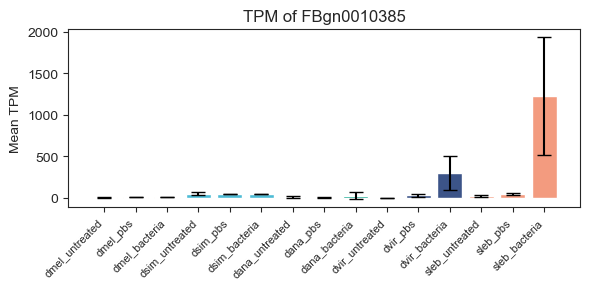

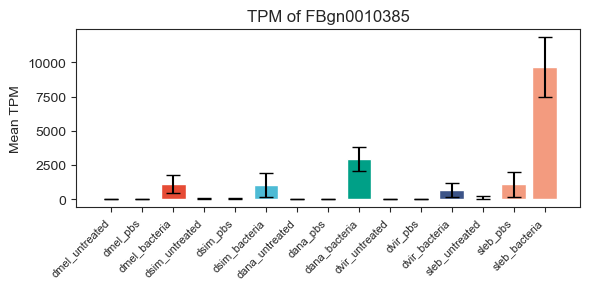

In [420]:
gene_id = 'FBgn0010385'  # dmel gene
plot_tpm('ef', gene_id)
plot_tpm('pr', gene_id)

# Method 2: bacteria only count table, and do Differential expression gene analysis in deseq2.

In [ ]:
merged_ef = pd.read_csv('merged_ef.txt', sep=' ')
import re

cols_to_keep = [merged_ef.columns[0]] + [col for col in merged_ef.columns if col.endswith(('_7', '_8', '_9'))]
bac_ef = merged_ef[cols_to_keep]

bac_ef.to_csv('merged_bac_ef.txt', sep=' ', index=False)

In [123]:
bac_ef

,0,dmel_7,dmel_8,dmel_9,dsim_7,dsim_8,dsim_9,dana_7,dana_8,dana_9,dvir_7,dvir_8,dvir_9,sleb_7,sleb_8,sleb_9
0,FBgn0000008,966,1197,987,1337,3430,3257,730,738,1047,862,611,1535,3985,1573,3550
1,FBgn0000014,356,468,400,344,882,821,1201,1008,1527,294,208,398,642,281,657
2,FBgn0000015,157,161,160,150,427,294,341,384,556,93,39,114,298,106,274
3,FBgn0000017,2922,3842,3205,3096,8612,7743,7336,6767,7925,2958,2210,5817,15666,5755,10858
4,FBgn0000018,614,783,732,390,1029,936,1012,924,1201,827,500,1158,1914,868,1928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10721,FBgn0288857,1031,1293,1074,783,1802,1680,2112,1690,2494,1151,717,1280,3522,1596,4413
10722,FBgn0288875,2454,2983,2670,2145,6566,6002,4064,3935,4613,2212,1472,3110,8229,3377,7894
10723,FBgn0288888,87,70,94,107,255,187,461,387,651,192,104,107,224,74,219
10724,FBgn0288966,1781,2237,1794,1756,4668,4240,4367,4106,5179,3443,2075,2372,7639,3112,7364


In [125]:
merged_pr = pd.read_csv('merged_pr.txt', sep=' ')

cols_to_keep = [merged_pr.columns[0]] + [col for col in merged_pr.columns if col.endswith(('_7', '_8', '_9'))]
bac_pr = merged_pr[cols_to_keep]

bac_pr.to_csv('merged_bac_pr.txt', sep=' ', index=False)

In [ ]:
dvir_dmel = pd.read_csv('res_table_dvir_tb.txt', sep=' ')

In [331]:
group_res = pd.read_csv('res_table_group_tb.txt', sep=' ')
group_res = group_res.merge(df_length, left_on='gene', right_on='gene_id', how='left')
group_res = group_res.drop_duplicates(subset='gene', keep='first')


In [348]:
group_res_pr = pd.read_csv('res_table_group_tb_pr.txt', sep=' ')
group_res_pr = group_res_pr.merge(df_length, left_on='gene', right_on='gene_id', how='left')
group_res_pr = group_res_pr.drop_duplicates(subset='gene', keep='first')


In [400]:
m2_ef

,gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_category,protein_id,gene_id,length
821,FBgn0001224,3886.804089,4.140934,0.309390,13.384180,7.481860e-41,2.433777e-38,Upregulated,FBpp0076181,FBgn0001224,186
832,FBgn0001229,787.183544,3.827113,0.763834,5.010398,5.431769e-07,5.741505e-06,Upregulated,FBpp0076225,FBgn0001229,199
2671,FBgn0005633,1735.595725,1.267799,0.328792,3.855928,1.152916e-04,6.945044e-04,Upregulated,FBpp0074679,FBgn0005633,182
2954,FBgn0010385,4814.264372,4.618674,0.744517,6.203587,5.519056e-10,1.080663e-08,Upregulated,FBpp0087518,FBgn0010385,92
3006,FBgn0010424,3420.967556,1.959518,0.322445,6.077059,1.224065e-09,2.224050e-08,Upregulated,FBpp0088546,FBgn0010424,155
...,...,...,...,...,...,...,...,...,...,...,...
22202,FBgn0259740,1669.210210,2.333350,0.206028,11.325429,9.819644e-30,1.800387e-27,Upregulated,FBpp0289322,FBgn0259740,77
23793,FBgn0263029,543.491673,2.982203,0.347534,8.581050,9.401129e-18,6.116192e-16,Upregulated,FBpp0297761,FBgn0263029,66
23976,FBgn0263251,1223.412875,13.959095,0.761373,18.334117,4.421400e-75,4.458540e-72,Upregulated,FBpp0076077,FBgn0263251,196
24888,FBgn0265313,688.926947,5.411468,1.736888,3.115611,1.835644e-03,7.454946e-03,Upregulated,FBpp0310839,FBgn0265313,45


In [349]:
m2_ef = group_res[(group_res['gene_category']== 'Upregulated') & (group_res['length'] < 200) & (group_res['baseMean'] > 500) ]


In [350]:
m2_pr = group_res_pr[(group_res_pr['gene_category']== 'Upregulated') & (group_res_pr['length'] < 200) & (group_res_pr['baseMean'] > 500) ]

In [351]:
m1m2_ef = m1_ef.merge(m2_ef, on='gene', how='outer')
m1m2_pr = m1_pr.merge(m2_pr, on='gene', how='outer')

In [352]:
m1m2_ef = m1m2_ef.drop_duplicates(subset='gene', keep='first')
m1m2_pr = m1m2_pr.drop_duplicates(subset='gene', keep='first')

m1m2_ef.to_csv('m1m2_ef.txt', sep=' ', index=True)
m1m2_pr.to_csv('m1m2_pr.txt', sep=' ', index=True)

m1m2_ef['gene'].to_csv('m1m2_ef_geneid.txt', sep=' ', header=False, index=False)
m1m2_pr['gene'].to_csv('m1m2_pr_geneid.txt', sep=' ', header=False, index=False)